## perplexity by temperature: GPT-4o and 'Does the electoral college work?'

In [158]:
import importlib
import utils.perplexity
importlib.reload(utils.perplexity)
from utils.perplexity import *

In [ ]:
import importlib
import utils.qualitymetrics
importlib.reload(utils.qualitymetrics)
from utils.qualitymetrics import *
from utils.quality_evauluator import EssayEvaluator

calculate perplexity statistics for each of the essays. save them into json files. 

In [142]:
gptdf = pd.read_pickle('./data/elect_gpt4o_evaldf.pkl')
gptdf.shape

(51, 26)

In [4]:
gptevaldf = pd.read_pickle("data/elect_gpt4o_evaldf.pkl")
for i, text in enumerate(gptevaldf.text):
    results = get_sequential_predictions_stats(text)
    statsdf = results_to_df(results)
    statsdf['perplexity'] = calculate_cumulative_perplexity(statsdf['actual_next_token_prob'])
    filename = f'./data/elect_gpt4o_stats/{gptevaldf.index[i]}.json'
    statsdf.to_json(filename, orient='records', lines=True)

In [5]:
statsdf['perplexity']

0      280.721288
1      934.824796
2      191.839404
3      593.768085
4      167.313446
          ...    
506     19.042657
507     18.932747
508     18.870000
509     18.955279
510     18.846472
Name: perplexity, Length: 511, dtype: float64

In [102]:

gptevaldf = pd.read_pickle("data/elect_evaldf.pkl")
for i, text in enumerate(gptevaldf.text.iloc[:3]):
    if i%10 ==0: 
        print(f'evaluating {i}/{len(gptevaldf)}th essay')
    results = get_sequential_predictions_stats(text)
    statsdf = results_to_df(results)
    statsdf['perplexity'] = calculate_cumulative_perplexity(statsdf['actual_next_token_prob'])
    filename = f'./data/elect_stats/{gptevaldf.index[i]}.json'
    statsdf.to_json(filename, orient='records', lines=True)


evaluating 0/682th essay


In [143]:
import pandas as pd
import glob
import numpy as np
import os

# Get the list of the first 10 JSON files
json_files = glob.glob('./data/elect_gpt4o_stats/*.json')

# Read each JSON file into a dataframe and concatenate them
df_list = [pd.read_json(file, orient='records', lines=True) for file in json_files]

# Combine the dataframes into a single dataframe
combined_df = pd.DataFrame([df.to_dict(orient='list') for df in df_list])

stat_cols = ['logit_mean', 'logit_std',
    'prob_mean', 'prob_std', 'log_prob_mean', 'log_prob_std',
    'actual_next_token_logit', 'actual_next_token_prob',
    'actual_next_token_log_prob_z_score', 'actual_next_token_prob_z_score',
    'actual_next_token_logit_z_score', 'actual_next_token_rank',
    'perplexity']
for col in stat_cols:
    combined_df[col] = [np.array(x) for x in combined_df[col]]

In [144]:
gptdf = gptdf.join(combined_df)

In [145]:
gptdf.to_pickle('./data/elect_gpt4o_evaldf_withstats.pkl')

plot statistics: how does temperature effect the perception of text by the judge which is gpt4omini? 

In [146]:
gptdf['wc_of_perceived_ai_text'] = gptdf['substrings_of_high_likelihood_of_ai'].apply(lambda l: np.sum([len(x.split()) for x in l]))
gptdf['number_of_perceived_ai_text'] = gptdf['substrings_of_high_likelihood_of_ai'].apply(lambda l: len(l))

In [147]:
int_evaluation_keys = ['number_of_spelling_mistakes', 'number_of_grammatical_errors', 'wc_of_perceived_ai_text', 'number_of_perceived_ai_text']
ordinal_evaluation_keys = [ 'sentence_complexity',
    'lexical_diversity',
    'vocabulary_sophistication',
    'coherence_score',
    'cohesion_score',
    'argument_structure',
    'readability_index',
    'sentence_clarity',
    'engagement_score',
    'sentiment_alignment',
    'style_consistency',
    'relevance_score',
    'evidence_support',
    'originality_and_creativity', 'likelihood_of_ai']
evaluation_keys = int_evaluation_keys + ordinal_evaluation_keys

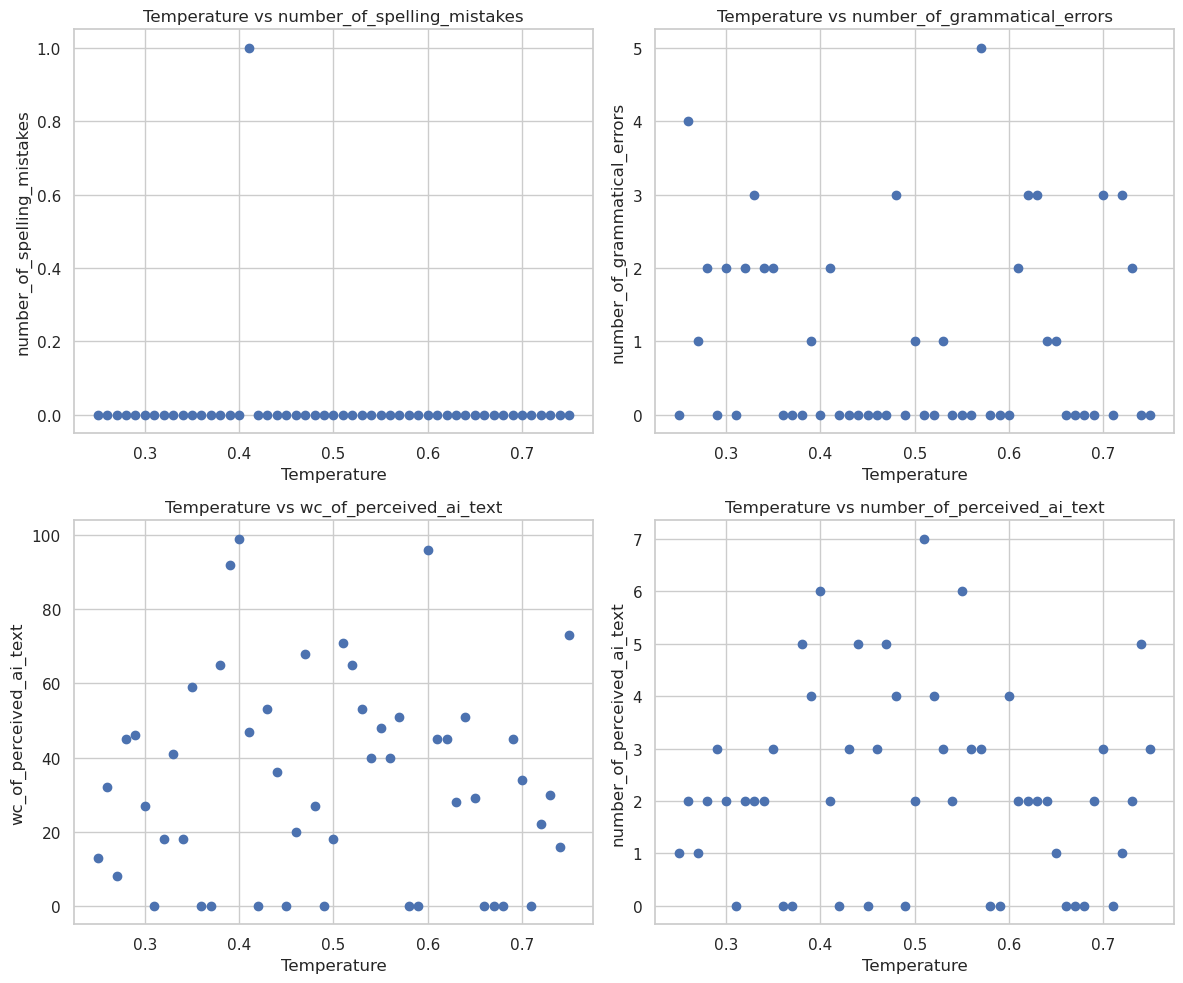

In [148]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, key in enumerate(int_evaluation_keys):
    ax = axs[i // 2, i % 2]
    ax.scatter(gptdf['temperature'], gptdf[key])
    ax.set_title(f'Temperature vs {key}')
    ax.set_xlabel('Temperature')
    ax.set_ylabel(key)

plt.tight_layout()
plt.show()
ax.set_xticks(np.arange(0.25, 0.76, 0.1))
ax.grid(True, which='both', axis='x')

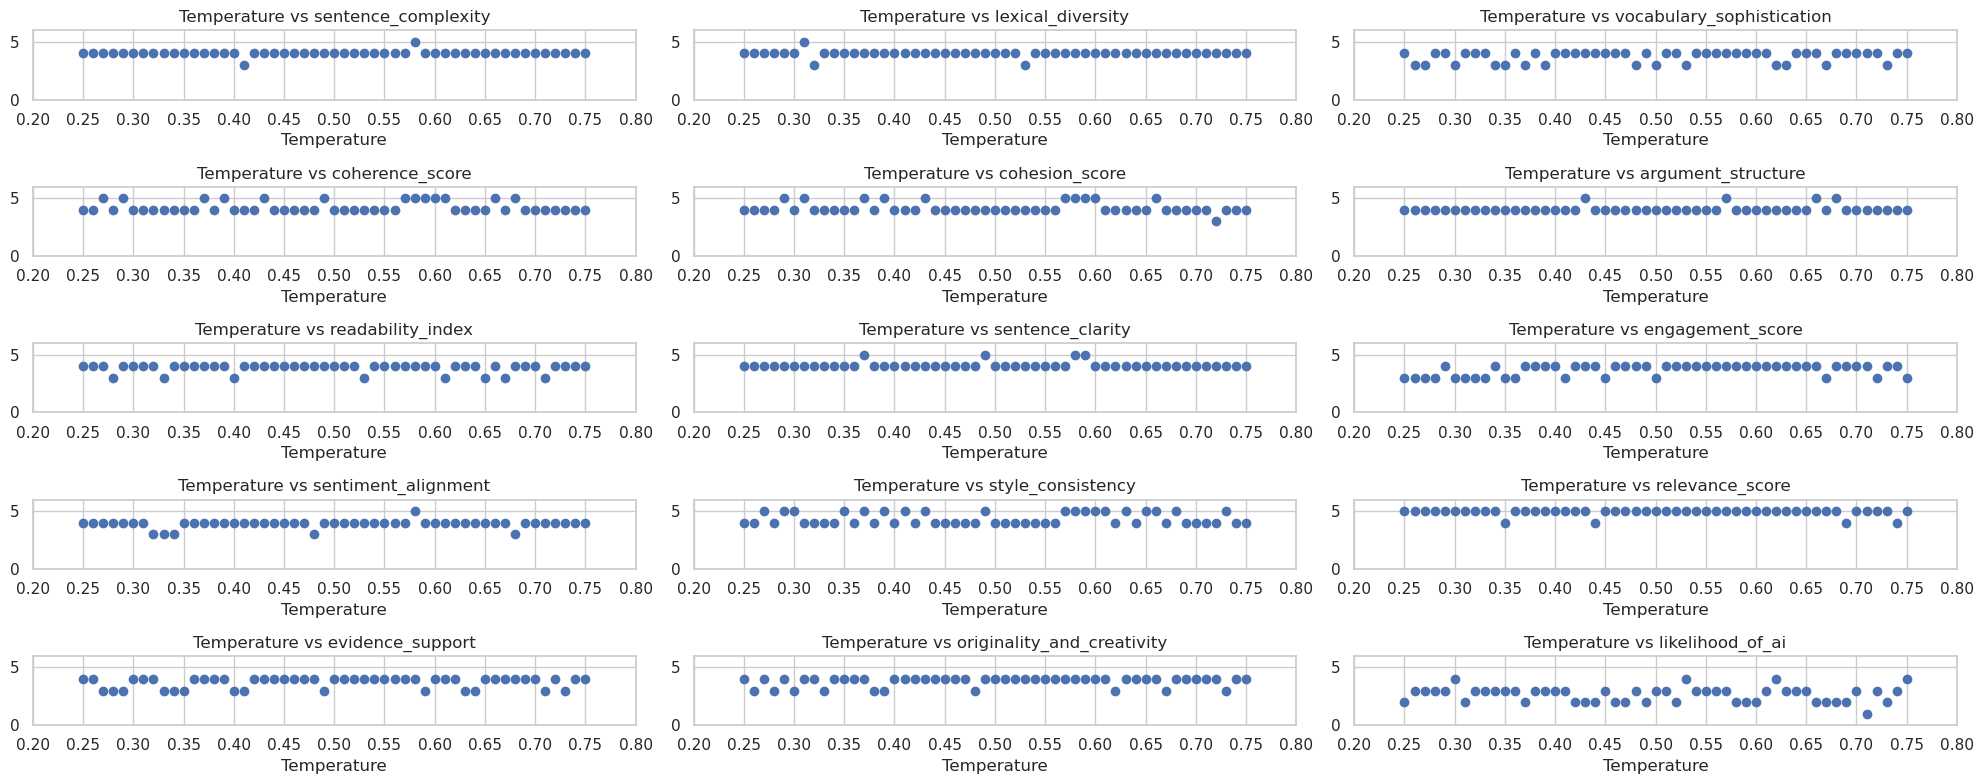

In [149]:
fig, axs = plt.subplots(5, 3, figsize=(20, 8))

for i, key in enumerate(ordinal_evaluation_keys):
    ax = axs[i // 3, i % 3]
    ax.scatter(gptdf['temperature'], gptdf[key])
    ax.set_title(f'Temperature vs {key}')
    ax.set_xlabel('Temperature')
    ax.set_ylim(0, 6)
    ax.set_xticks(np.arange(0.2, 0.81, 0.05))
    ax.grid(True, which='both', axis='x')

plt.tight_layout()
plt.show()

correlation shows nothing exciting except for engagement score, maybe. 

In [150]:
from scipy.stats import pearsonr

for key in int_evaluation_keys + ordinal_evaluation_keys:
    correlation, p_value = pearsonr(gptdf['temperature'], gptdf[key])
    print(f'Correlation between temperature and {key}: {correlation:.4f}, p-value: {p_value:.4f}')

Correlation between temperature and number_of_spelling_mistakes: -0.0865, p-value: 0.5463
Correlation between temperature and number_of_grammatical_errors: -0.0523, p-value: 0.7153
Correlation between temperature and wc_of_perceived_ai_text: -0.0155, p-value: 0.9139
Correlation between temperature and number_of_perceived_ai_text: -0.0303, p-value: 0.8331
Correlation between temperature and sentence_complexity: 0.1144, p-value: 0.4243
Correlation between temperature and lexical_diversity: -0.0220, p-value: 0.8780
Correlation between temperature and vocabulary_sophistication: 0.1672, p-value: 0.2410
Correlation between temperature and coherence_score: 0.0092, p-value: 0.9491
Correlation between temperature and cohesion_score: -0.1333, p-value: 0.3509
Correlation between temperature and argument_structure: 0.1685, p-value: 0.2373
Correlation between temperature and readability_index: -0.0659, p-value: 0.6457
Correlation between temperature and sentence_clarity: 0.0149, p-value: 0.9175
Cor

# now plot perplexity and other statistics, overlapped, with temperature as hue. 

In [151]:
gptdf.columns

Index(['temperature', 'text', 'word_count', 'source', 'model',
       'number_of_grammatical_errors', 'number_of_spelling_mistakes',
       'grammatical_errors', 'spelling_mistakes', 'sentence_complexity',
       'lexical_diversity', 'vocabulary_sophistication', 'coherence_score',
       'cohesion_score', 'argument_structure', 'readability_index',
       'sentence_clarity', 'engagement_score', 'sentiment_alignment',
       'style_consistency', 'relevance_score', 'evidence_support',
       'originality_and_creativity', 'likelihood_of_ai',
       'reasoning_of_likelihood_of_ai', 'substrings_of_high_likelihood_of_ai',
       'i', 'current_token', 'actual_next_token', 'logit_mean', 'logit_std',
       'prob_mean', 'prob_std', 'log_prob_mean', 'log_prob_std',
       'actual_next_token_logit', 'actual_next_token_prob',
       'actual_next_token_log_prob_z_score', 'actual_next_token_prob_z_score',
       'actual_next_token_logit_z_score', 'actual_next_token_rank',
       'perplexity', 'wc_of_

In [152]:
gptdf['actual_next_token_prob'].sample().iloc[0][-10:]

array([0.00106715, 0.01083888, 0.99939048, 0.32830608, 0.51889253,
       0.99040973, 0.03196573, 0.95182222, 0.00638877, 0.99600804])

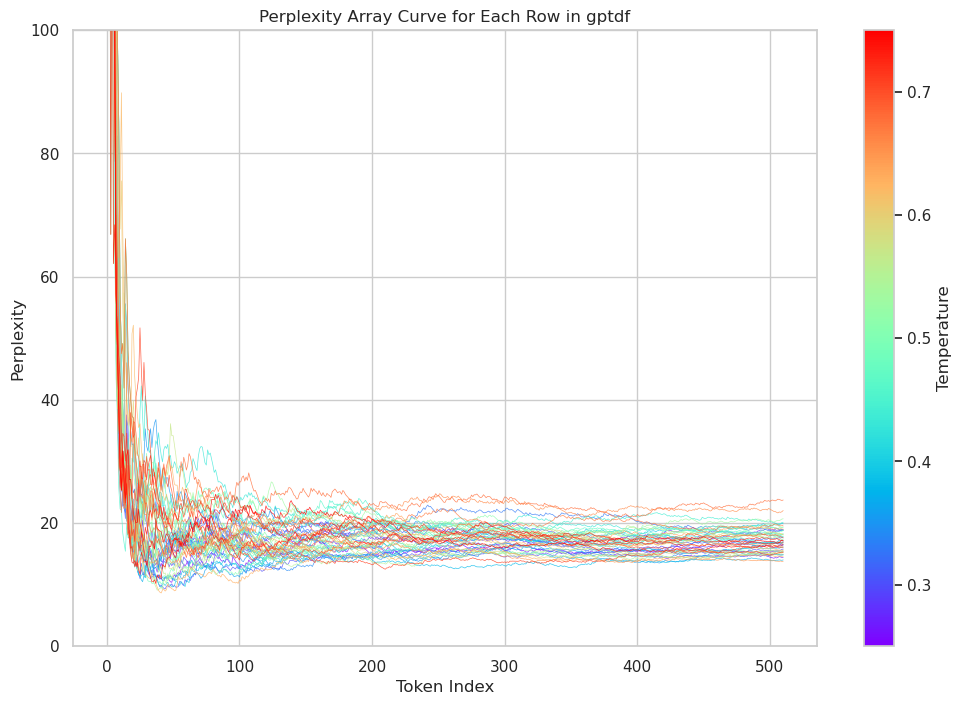

In [153]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Normalize the temperature for color mapping
norm = plt.Normalize(gptdf['temperature'].min(), gptdf['temperature'].max())
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
sm.set_array([])

# Plot each row's perplexity array with temperature as hue
for i, row in gptdf.iterrows():
    perplexity_array = row['perplexity']
    temperature = row['temperature']
    ax.plot(perplexity_array, color=sm.to_rgba(temperature), label=f'Temp: {temperature:.2f}', alpha=0.8, linewidth=0.5)

# Add color bar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Temperature')

# Set y axis scale
ax.set_ylim(0, 100)

# Set labels and title
ax.set_xlabel('Token Index')
ax.set_ylabel('Perplexity')
ax.set_title('Perplexity Array Curve for Each Row in gptdf')

plt.show()

# plot the perplexity calculated with window of last 10 words

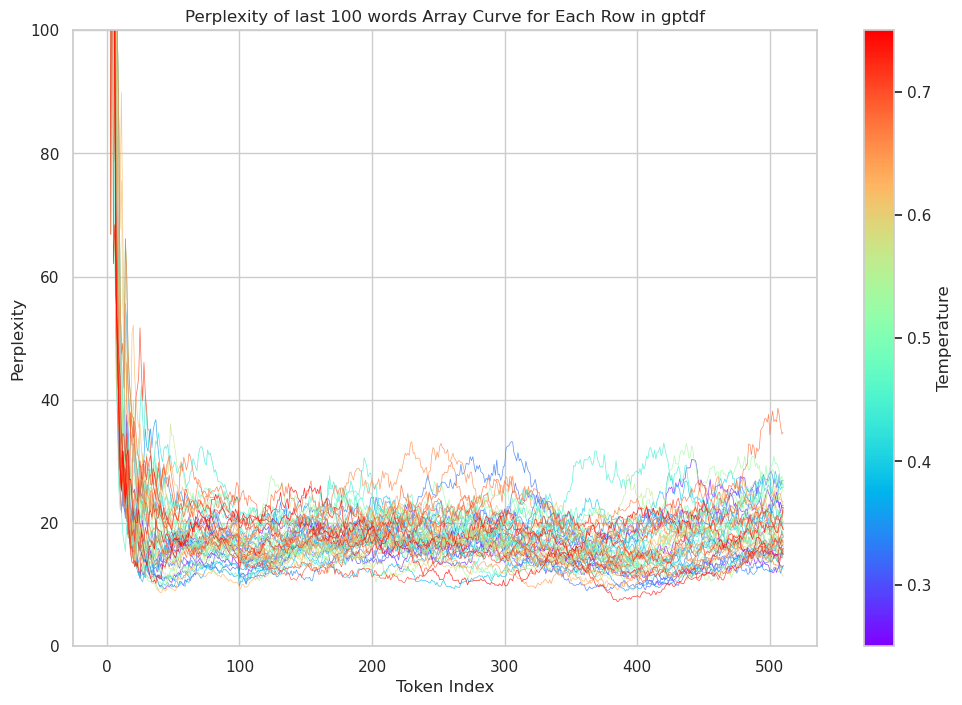

In [169]:
import seaborn as sns

import matplotlib.pyplot as plt

import importlib
import utils.perplexity
importlib.reload(utils.perplexity)
from utils.perplexity import *
gptdf['perplexity_w100'] = gptdf['actual_next_token_prob'].apply(lambda x: calculate_windowed_perplexity(x, window=100))


# Set the style of the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Normalize the temperature for color mapping
norm = plt.Normalize(gptdf['temperature'].min(), gptdf['temperature'].max())
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
sm.set_array([])

# Plot each row's perplexity array with temperature as hue
for i, row in gptdf.iterrows():
    perplexity_array = row['perplexity_w100']
    temperature = row['temperature']
    ax.plot(perplexity_array, color=sm.to_rgba(temperature), label=f'Temp: {temperature:.2f}', alpha=0.8, linewidth=0.5)

# Add color bar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Temperature')

# Set y axis scale
ax.set_ylim(0, 100)

# Set labels and title
ax.set_xlabel('Token Index')
ax.set_ylabel('Perplexity')
ax.set_title('Perplexity of last 100 words Array Curve for Each Row in gptdf')

plt.show()

research the relationship between temperature and some other statistics. 

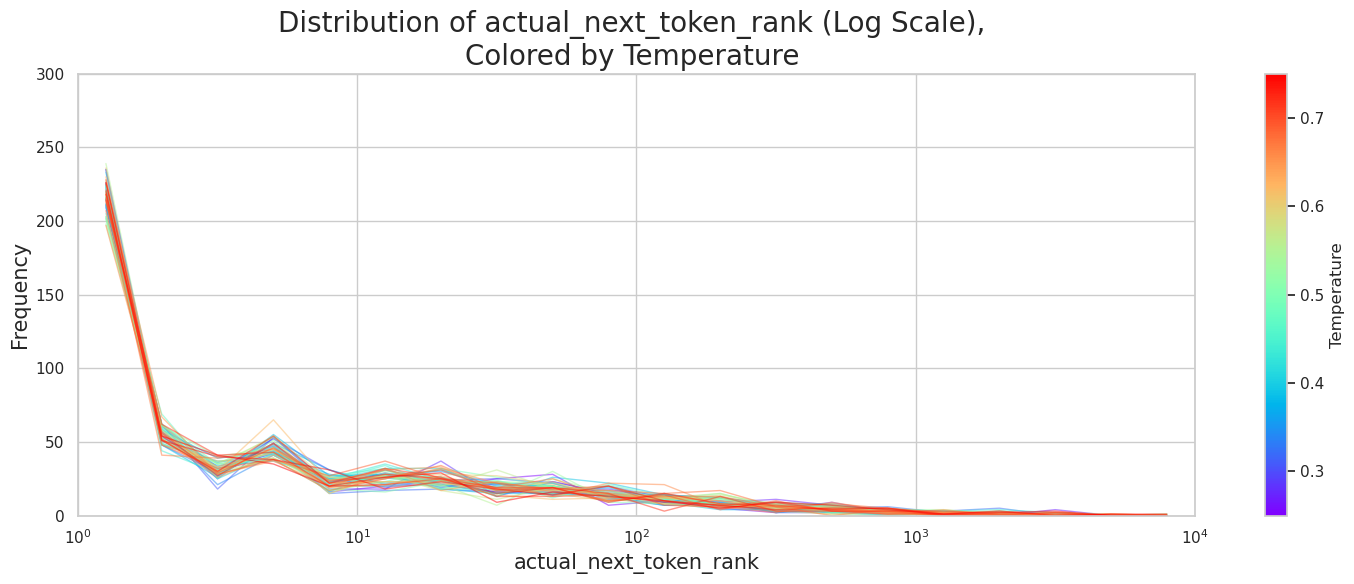

In [27]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 6))

# Normalize the temperature for color mapping
norm = plt.Normalize(gptdf['temperature'].min(), gptdf['temperature'].max())
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
sm.set_array([])
# set bins for histogram
bins = np.logspace(np.log10(1), np.log10(10000), 21)

# Plot each row's perplexity array with temperature as hue
for i, row in gptdf.iterrows():
    rank_array = row['actual_next_token_rank']
    temperature = row['temperature']
    #ax.plot(perplexity_array, color=sm.to_rgba(temperature), label=f'Temp: {temperature:.2f}', alpha=0.8, linewidth=0.5)

    filtered_data = rank_array

    # Plot histogram with log-spaced bins and set x-axis to log scale
    # ax.hist(filtered_data, bins=bins, color='green', alpha=0.7)
    counts, _ = np.histogram(filtered_data, bins=bins)
    ax.set_xscale('log')  # Set log scale after plotting
    # Calculate the middle of each bin in log scale
    bin_middles = np.sqrt(bins[1:] * bins[:-1])
    # Create a line plot
    sns.lineplot(x=bin_middles, y=counts, ax=ax, color=sm.to_rgba(temperature), alpha=0.5, linewidth=1)

# Add color bar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Temperature')

# Set x,y axis scale and limits
ax.set_ylim(0, 300)
ax.set_xlim(1, 10000)
ax.set_xscale('log')  # Set log scale after plotting

# Add title and labels
ax.set_title('Distribution of actual_next_token_rank (Log Scale), \nColored by Temperature ', fontsize=20)
ax.set_xlabel('actual_next_token_rank', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)


plt.tight_layout()
plt.show()


See if the same phenomenon is true for the human sessions. 

In [129]:
corpusdf = pd.read_pickle('./data/elect_evaldf.pkl')
corpusdf.shape

(682, 33)

In [113]:
len(df_list)

682

In [117]:
import pandas as pd
import glob
import numpy as np
import os

# Get the list of the first 10 JSON files
json_files = glob.glob('./data/elect_stats/*.json')

# Read each JSON file into a dataframe and concatenate them
df_list = [pd.read_json(file, orient='records', lines=True) for file in json_files]


In [124]:

# Combine the dataframes into a single dataframe
combined_df = pd.DataFrame([df.to_dict(orient='list') for df in df_list])

In [126]:
stat_cols = ['logit_mean', 'logit_std',
    'prob_mean', 'prob_std', 'log_prob_mean', 'log_prob_std',
    'actual_next_token_logit', 'actual_next_token_prob',
    'actual_next_token_log_prob_z_score', 'actual_next_token_prob_z_score',
    'actual_next_token_logit_z_score', 'actual_next_token_rank',
    'perplexity']
for col in stat_cols:
    combined_df[col] = [np.array(x) for x in combined_df[col]]

In [130]:
corpusdf = corpusdf.join(combined_df)

In [131]:
corpusdf.to_pickle('./data/elect_evaldf_withstats.pkl')

In [132]:
# Get the Set1 colormap
set1_colors = sns.color_palette("Set2")

# Switch the first two colors
custom_palette = set1_colors.copy()
custom_palette[0], custom_palette[1] = custom_palette[1], custom_palette[0]


In [133]:
big_palette = sns.color_palette("Set1").copy() + sns.color_palette("Set2").copy() + sns.color_palette("Set3").copy()

human_list = ['persuade_corpus', 'train_essays']
# Top tier models for text generation
ai_top_list = [
    'radekgpt4', 'nima_gpt4', 'chat_gpt_moth',
    'darragh_claude_v7', 'llama_falcon_v3_falcon_180b',
    'llama_70b_v1', 'llama2_chat', 'falcon_180b_v1', 
    'mistral7binstruct_v2', 'mistralai/Mistral-7B-Instruct-v0.1', 'llama_70b_v1', 'Mistral7B_CME_v7']
source_list = human_list + ai_top_list
color_dict = dict(zip(source_list, big_palette[:len(source_list)]))

In [134]:
corpusdf['source'].value_counts()

source
persuade_corpus                       331
Mistral7B_CME_v7                       50
darragh_claude_v7                      50
llama_falcon_v3_falcon_180b            50
mistralai/Mistral-7B-Instruct-v0.1     50
nima_gpt4                              50
radekgpt4                              50
llama_70b_v1                           31
train_essays                           20
Name: count, dtype: int64

In [135]:
row['index']

19211

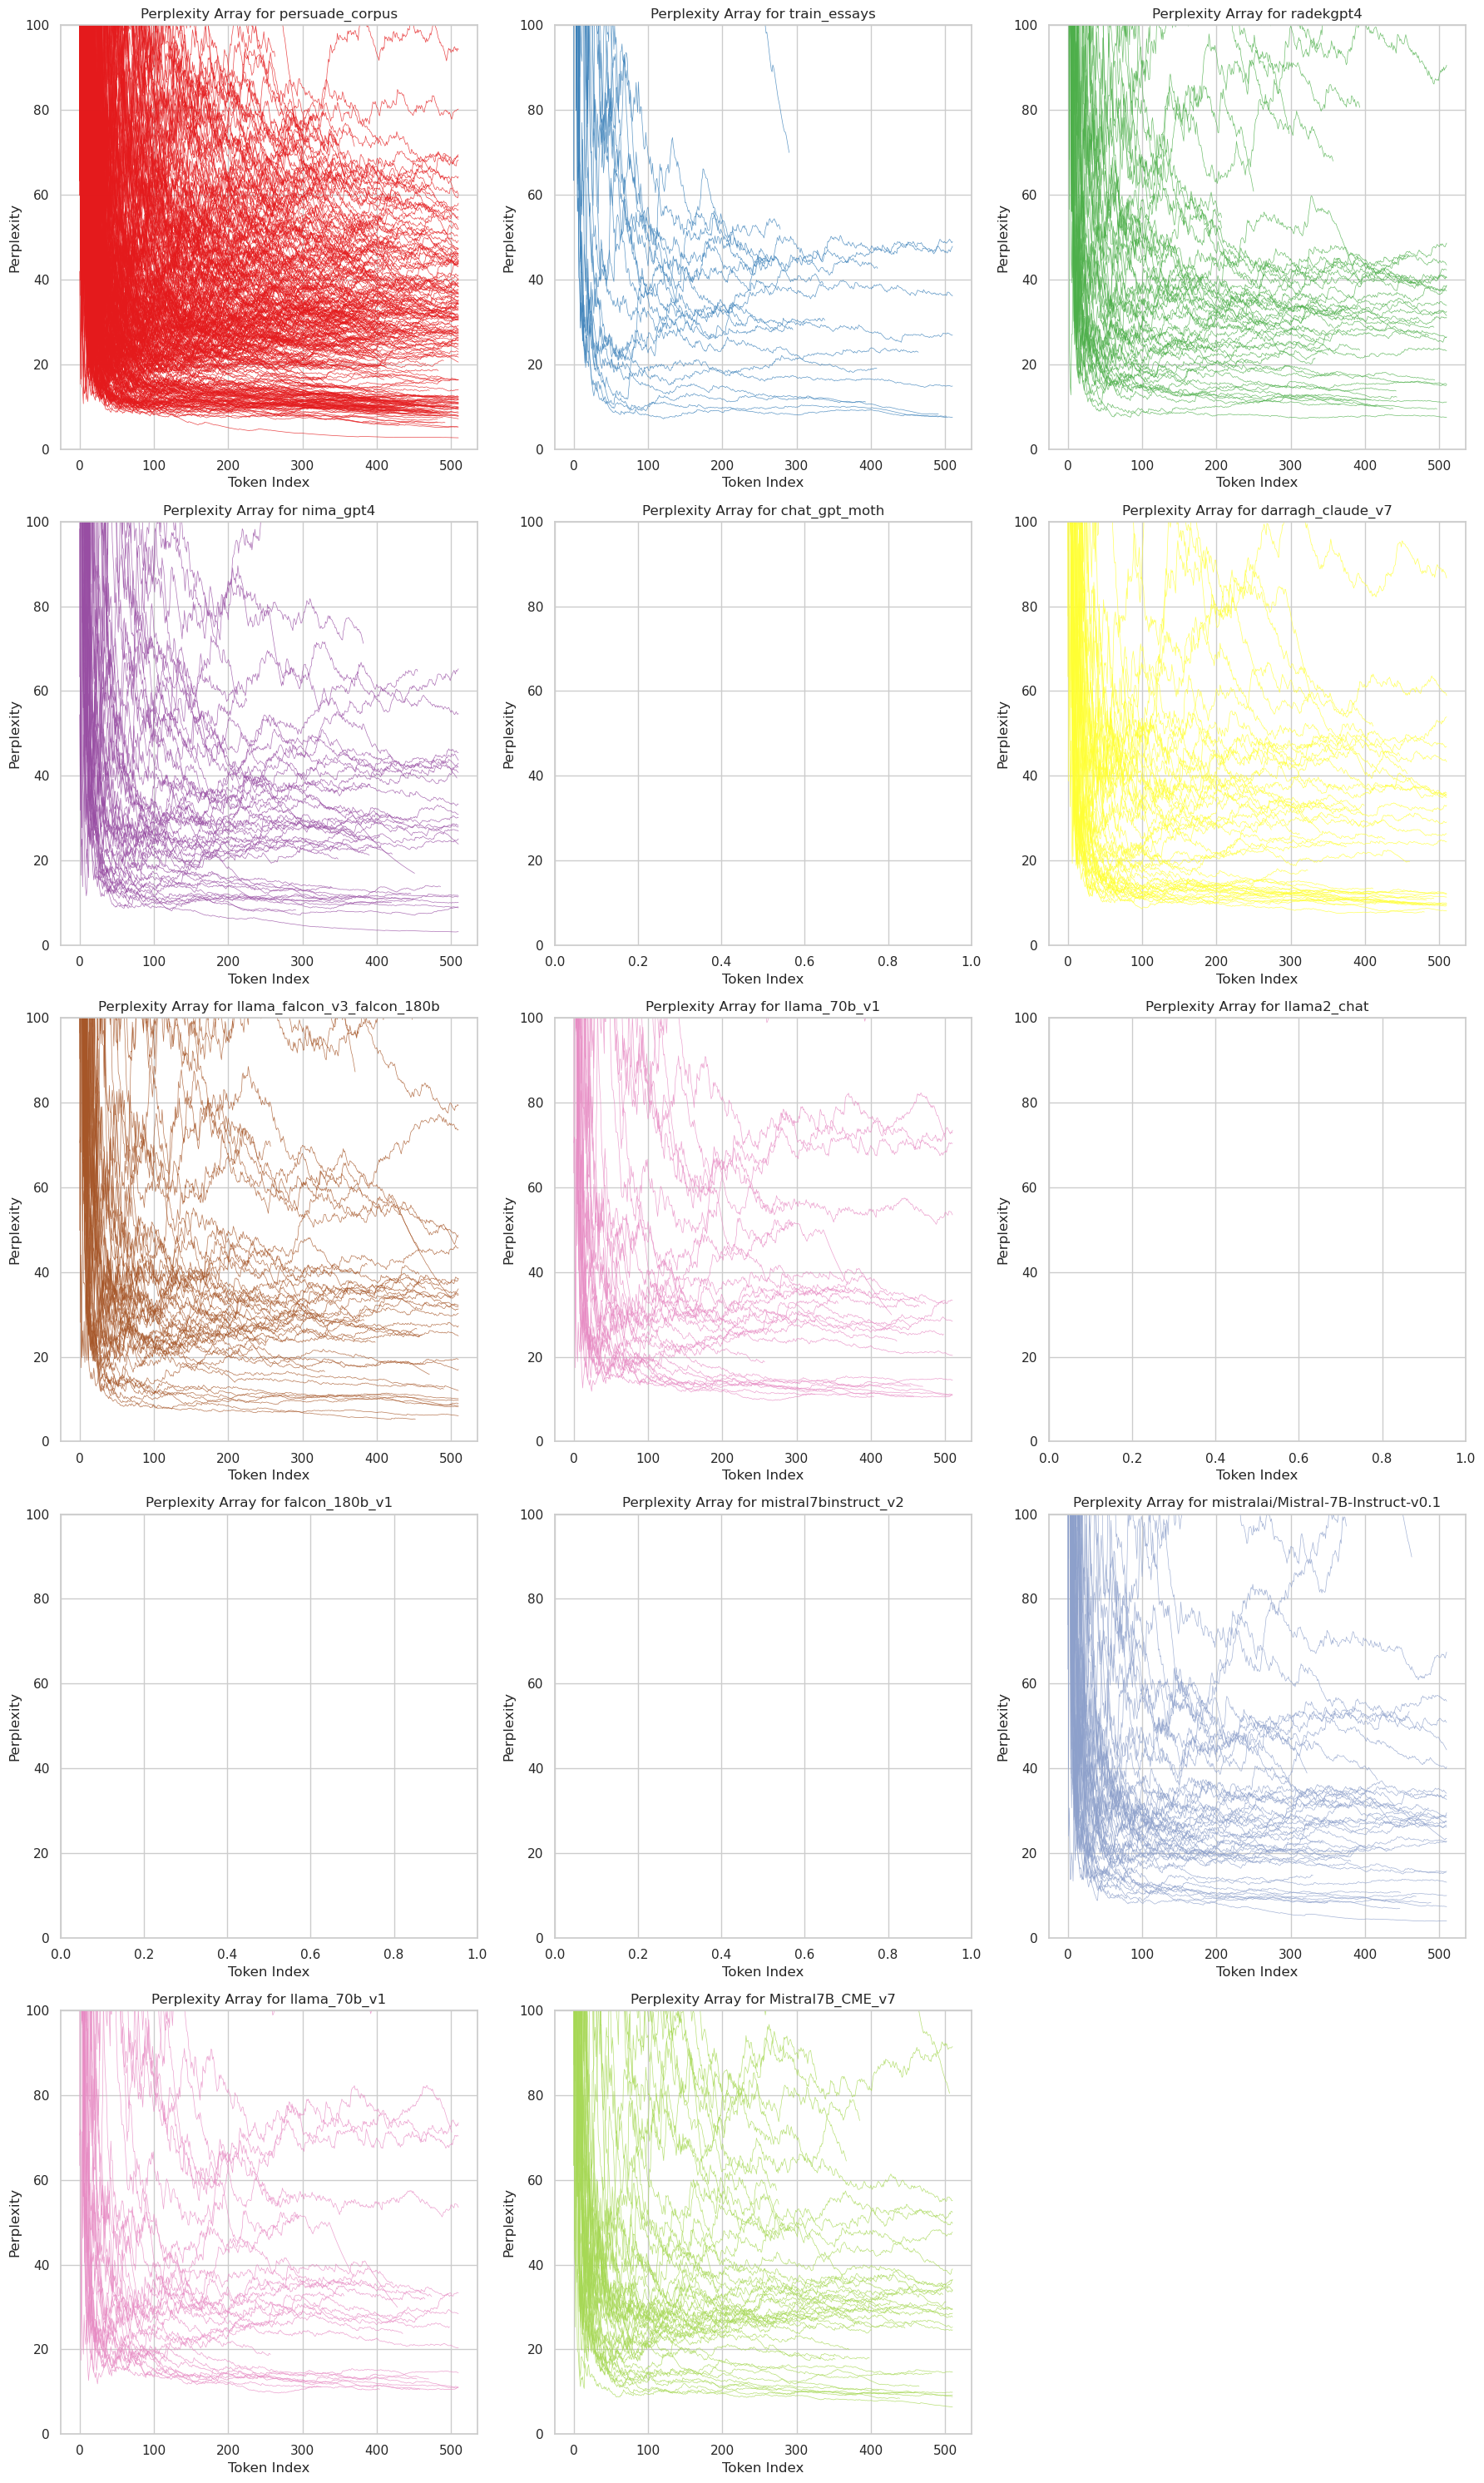

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Get unique sources
unique_sources = source_list

# Calculate the number of rows needed
num_rows = (len(unique_sources) + 2) // 3

# Create a figure and axis
fig, axs = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each row's perplexity array with source as hue
for i, source in enumerate(unique_sources):
    ax = axs[i]
    for _, row in corpusdf[corpusdf['source'] == source].iterrows():
        perplexity_array = row['perplexity']
        ax.plot(perplexity_array, color=color_dict[source], label=source, alpha=0.8, linewidth=0.5)
    ax.set_title(f'Perplexity Array for {source}')
    ax.set_ylim(0, 100)
    ax.set_xlabel('Token Index')
    ax.set_ylabel('Perplexity')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


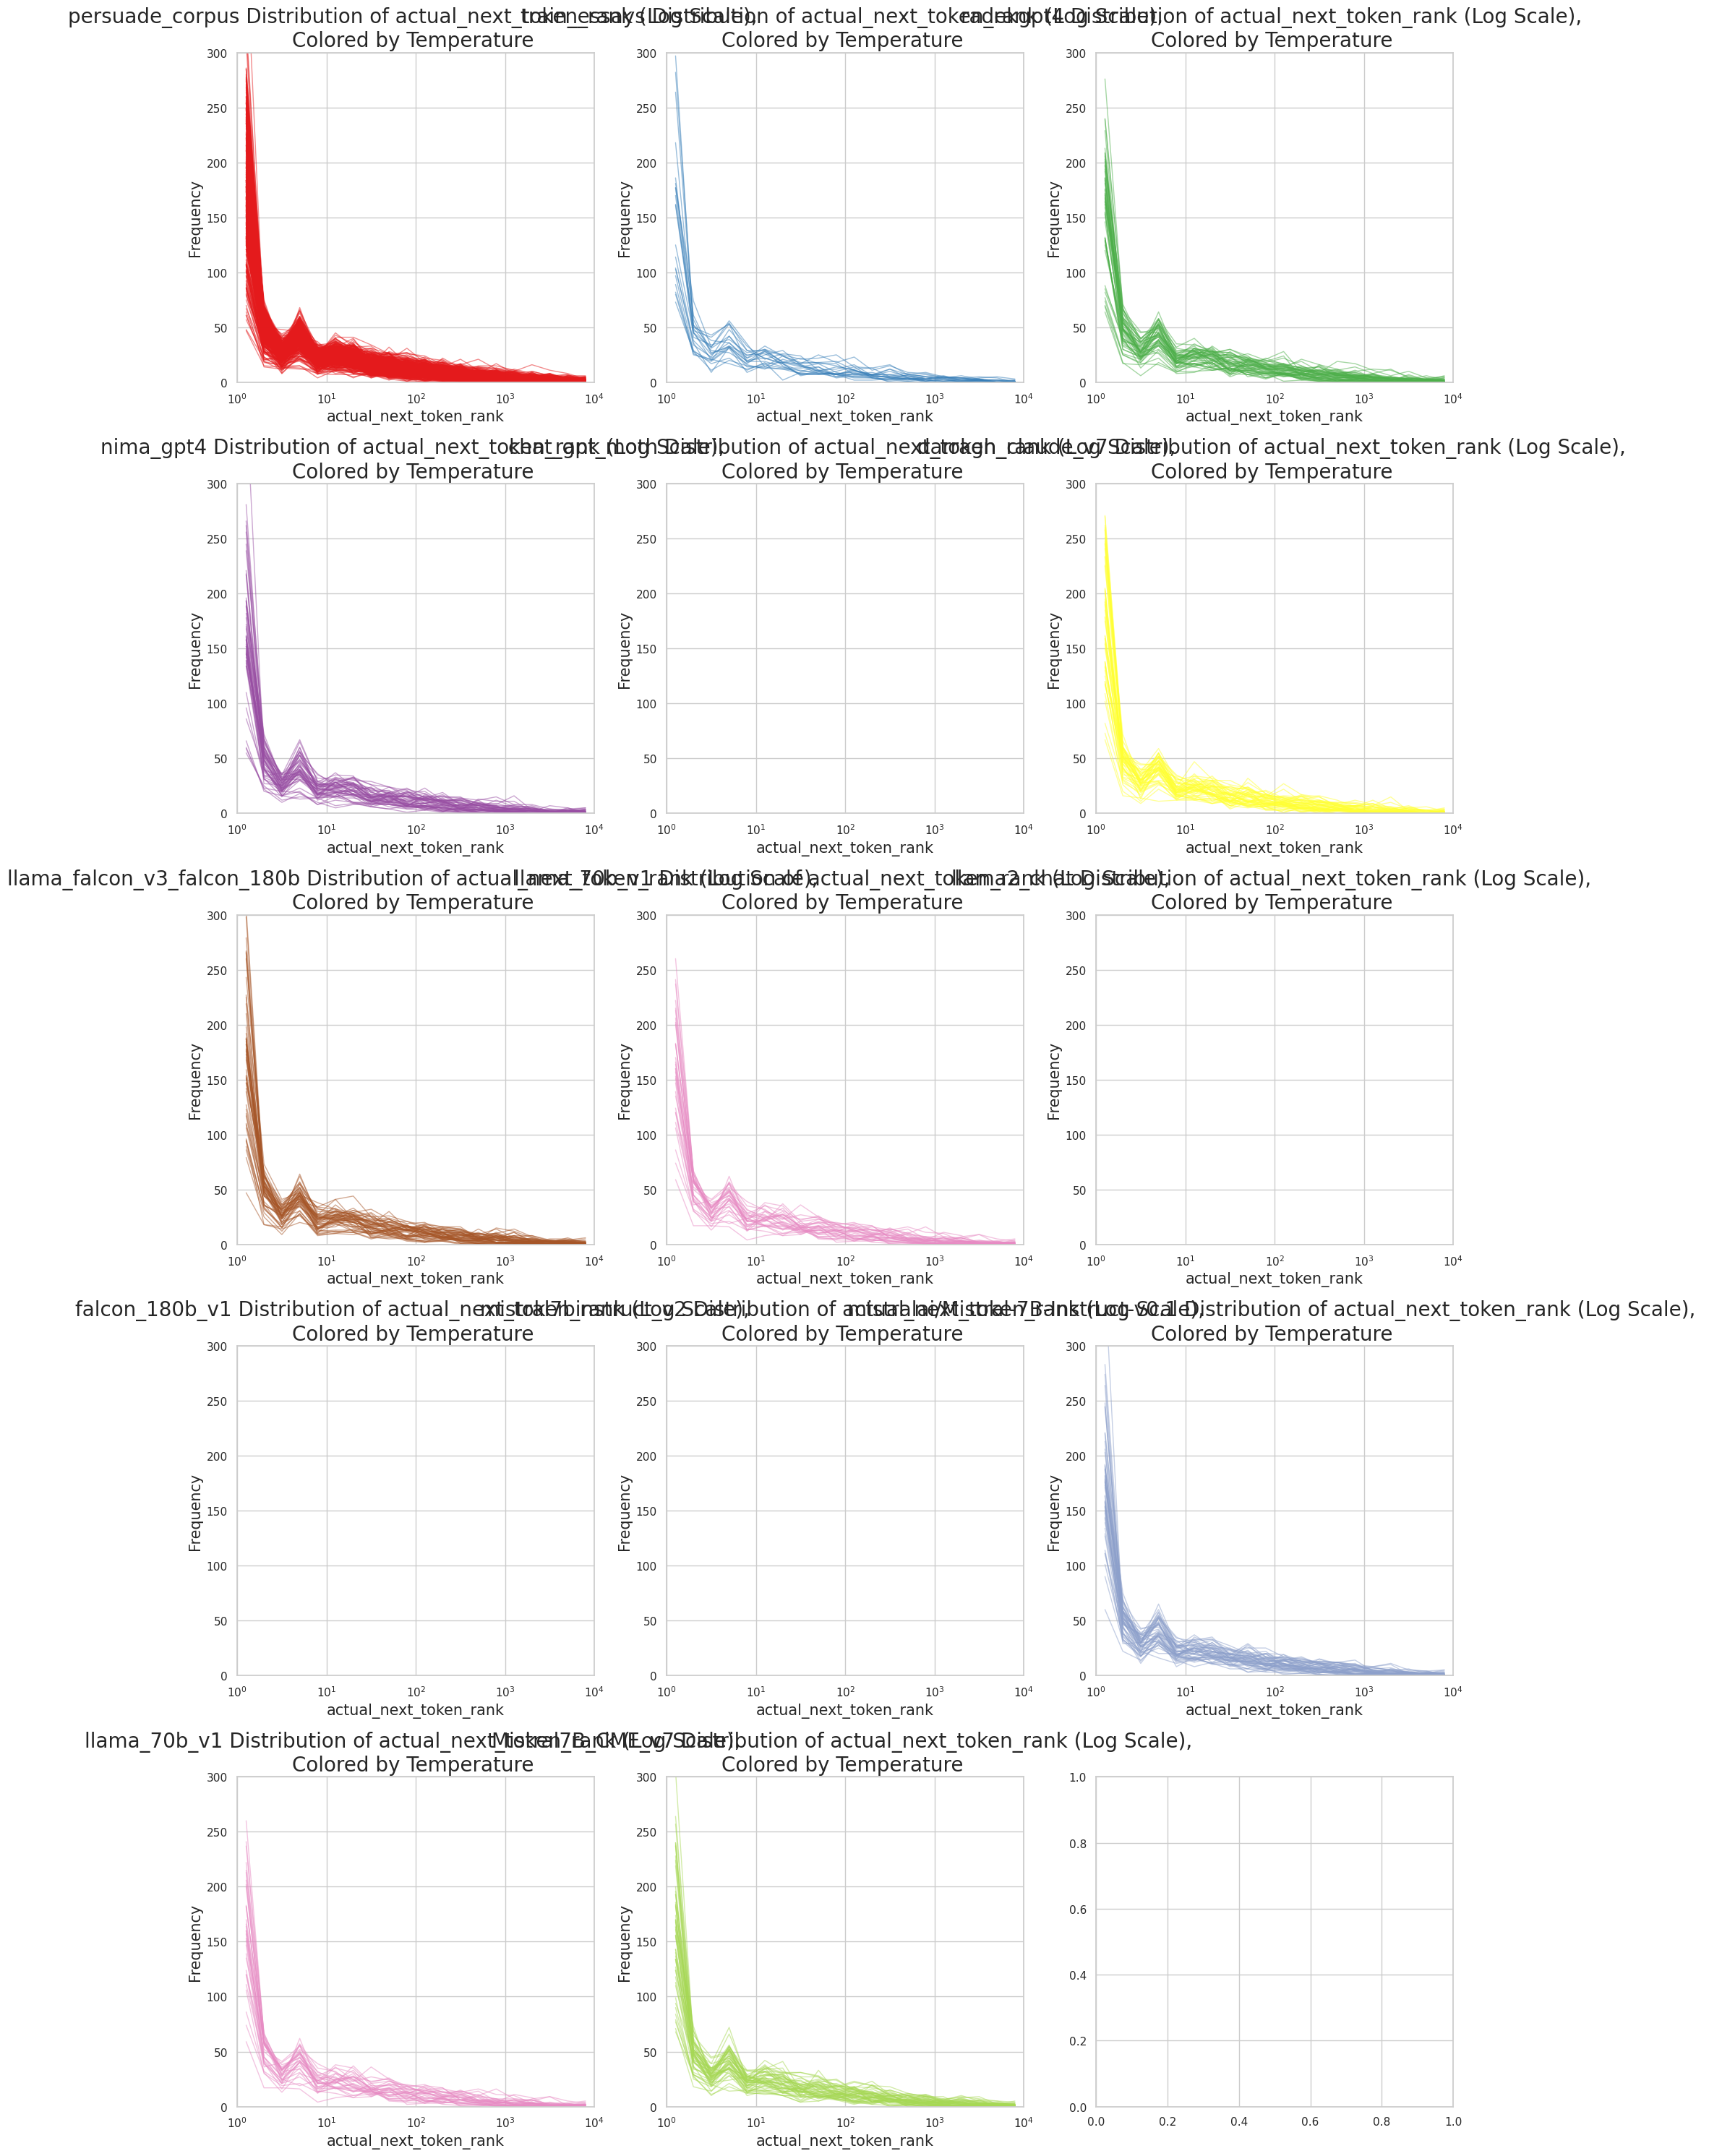

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Get unique sources
unique_sources = source_list

# Calculate the number of rows needed
num_rows = (len(unique_sources) + 2) // 3

# Create a figure and axis
fig, axs = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each row's perplexity array with source as hue
for i, source in enumerate(unique_sources):
    ax = axs[i]
    for _, row in corpusdf[corpusdf['source'] == source].iterrows():
        rank_array = row['actual_next_token_rank']
        
        filtered_data = rank_array

        # Plot histogram with log-spaced bins and set x-axis to log scale
        # ax.hist(filtered_data, bins=bins, color='green', alpha=0.7)
        counts, _ = np.histogram(filtered_data, bins=bins)
        ax.set_xscale('log')  # Set log scale after plotting
        # Calculate the middle of each bin in log scale
        bin_middles = np.sqrt(bins[1:] * bins[:-1])
        # Create a line plot
        sns.lineplot(x=bin_middles, y=counts, ax=ax, color=color_dict[source], alpha=0.5, linewidth=1)

    # Set x,y axis scale and limits
    ax.set_ylim(0, 300)
    ax.set_xlim(1, 10000)
    ax.set_xscale('log')  # Set log scale after plotting

    # Add title and labels
    ax.set_title(f'{source} Distribution of actual_next_token_rank (Log Scale), \nColored by Temperature ', fontsize=20)
    ax.set_xlabel('actual_next_token_rank', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)

plt.tight_layout()
plt.show()

